In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

/kaggle/input/fake-news-detection-dataset/Task3_english_training.csv
/kaggle/input/fake-news-detection-dataset/Task3_english_dev.csv
/kaggle/input/fake-news-detection-dataset/English_data_test_release_with_rating.csv


In [2]:
data_train = pd.read_csv('/kaggle/input/fake-news-detection-dataset/Task3_english_training.csv')
data_validation = pd.read_csv('/kaggle/input/fake-news-detection-dataset/Task3_english_dev.csv')
data_test = pd.read_csv('/kaggle/input/fake-news-detection-dataset/English_data_test_release_with_rating.csv')

data_train['our rating'] = data_train['our rating'].str.lower()
data_validation['our rating'] = data_validation['our rating'].str.lower()
data_test['our rating'] = data_test['our rating'].str.lower()

def makeLabelsUnique(labels):
    unique_labels = set(labels)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    labels = [label_map[label] for label in labels]
    return labels

data_train['our rating'] = makeLabelsUnique(data_train['our rating'].values)
data_validation['our rating'] = makeLabelsUnique(data_validation['our rating'].values)
data_test['our rating'] = makeLabelsUnique(data_test['our rating'].values)

train_df = data_train[['text', 'title', 'our rating']].copy()
val_df = data_validation[['text', 'title', 'our rating']].copy()

train_dataset = train_df.reset_index(drop=True)
val_dataset = val_df.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VAL Dataset: {}".format(val_dataset.shape))

TRAIN Dataset: (900, 3)
VAL Dataset: (364, 3)


In [3]:
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn
import torch

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data['our rating']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_dataset = CustomDataset(train_dataset, tokenizer, 512)
val_dataset = CustomDataset(val_dataset, tokenizer, 512)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

val_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [5]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)
    
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), num_classes=4)
model.to(device)

def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

LEARNING_RATE = 1e-05
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
import gc
from sklearn import metrics

def train(epoch):
    model.train()
    gc.collect()
    torch.cuda.empty_cache()
    
    for idx, data in enumerate(train_dataloader, 0):
        batch_size = data['ids'].size(0)
        sub_batch_size = batch_size // 2 
        total_loss = 0
        
        for i in range(0, batch_size, sub_batch_size):
            end_idx = min(i + sub_batch_size, batch_size)
            
            sub_ids = data['ids'][i:end_idx].to(device, dtype=torch.long)
            sub_mask = data['mask'][i:end_idx].to(device, dtype=torch.long)
            sub_token_type_ids = data['token_type_ids'][i:end_idx].to(device, dtype=torch.long)
            sub_targets = data['targets'][i:end_idx].to(device, dtype=torch.long)
            
            outputs = model(sub_ids, sub_mask, sub_token_type_ids)
            loss = loss_fn(outputs, sub_targets)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            del outputs, sub_ids, sub_mask, sub_token_type_ids, sub_targets
            torch.cuda.empty_cache()
        
        if idx % 50 == 0: 
            print(f'Epoch: {epoch}, Batch: {idx}, Loss: {total_loss/2:.4f}')

def validation():
    model.eval()
    fin_targets = []
    fin_outputs = []
    
    with torch.no_grad():
        for data in val_dataloader:
            batch_size = data['ids'].size(0)
            sub_batch_size = batch_size // 2
            
            for i in range(0, batch_size, sub_batch_size):
                end_idx = min(i + sub_batch_size, batch_size)
                
                sub_ids = data['ids'][i:end_idx].to(device, dtype=torch.long)
                sub_mask = data['mask'][i:end_idx].to(device, dtype=torch.long)
                sub_token_type_ids = data['token_type_ids'][i:end_idx].to(device, dtype=torch.long)
                sub_targets = data['targets'][i:end_idx].to(device, dtype=torch.long)
                
                outputs = model(sub_ids, sub_mask, sub_token_type_ids)
                
                sub_targets = sub_targets.cpu().numpy()
                predictions = torch.argmax(outputs, dim=1).cpu().numpy()
                
                fin_targets.extend(sub_targets)
                fin_outputs.extend(predictions)
                
                del outputs, sub_ids, sub_mask, sub_token_type_ids, sub_targets
                torch.cuda.empty_cache()
                
    return fin_outputs, fin_targets

EPOCHS = 5
best_val_f1 = 0
patience = 3
patience_counter = 0

train_losses = []
val_f1_scores = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}")
    
    train(epoch)
    
    outputs, targets = validation()
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    
    val_f1_scores.append(f1_score_macro)
    val_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}: Accuracy Score = {accuracy}")
    print(f"Epoch {epoch+1}: F1 Score (Micro) = {f1_score_micro}")
    print(f"Epoch {epoch+1}: F1 Score (Macro) = {f1_score_macro}")
    
    if f1_score_macro > best_val_f1:
        best_val_f1 = f1_score_macro
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Starting epoch 1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Batch: 0, Loss: 1.4891
Epoch 1: Accuracy Score = 0.32142857142857145
Epoch 1: F1 Score (Micro) = 0.32142857142857145
Epoch 1: F1 Score (Macro) = 0.14608407465550324
Starting epoch 2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 1, Batch: 0, Loss: 1.3026
Epoch 2: Accuracy Score = 0.3791208791208791
Epoch 2: F1 Score (Micro) = 0.37912087912087916
Epoch 2: F1 Score (Macro) = 0.27270010476279827
Starting epoch 3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 2, Batch: 0, Loss: 1.0584
Epoch 3: Accuracy Score = 0.44505494505494503
Epoch 3: F1 Score (Micro) = 0.44505494505494503
Epoch 3: F1 Score (Macro) = 0.3328021191751977
Starting epoch 4


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 3, Batch: 0, Loss: 1.0416
Epoch 4: Accuracy Score = 0.47802197802197804
Epoch 4: F1 Score (Micro) = 0.47802197802197804
Epoch 4: F1 Score (Macro) = 0.3498406178855412
Starting epoch 5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 4, Batch: 0, Loss: 0.8063
Epoch 5: Accuracy Score = 0.5274725274725275
Epoch 5: F1 Score (Micro) = 0.5274725274725275
Epoch 5: F1 Score (Macro) = 0.36883969341161116


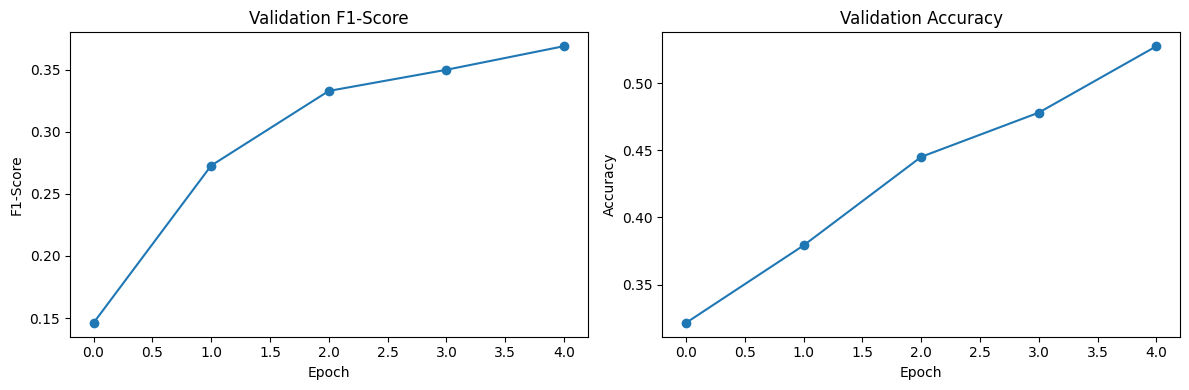

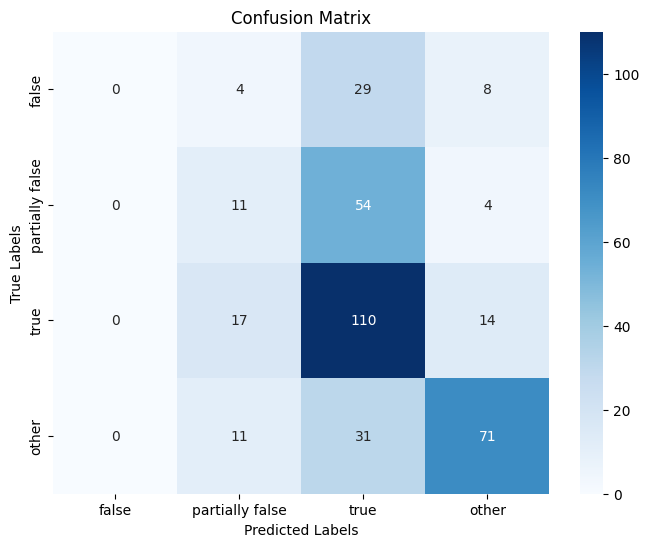

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(val_f1_scores, marker='o')
ax1.set_title('Validation F1-Score')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('F1-Score')

ax2.plot(val_accuracies, marker='o')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(targets, outputs)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['false', 'partially false', 'true', 'other'],
            yticklabels=['false', 'partially false', 'true', 'other'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()